In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer # , CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
import pandas as pd
from time import time
import numpy as np

RAW_DATA_PATH = r"raw_data/Relevant vs Irrelevant.xlsx"


## final parameters were fine-tuned using GridSearchCV ; more in processing.py file
classifiers = {
    "MultinomialNB" : MultinomialNB(alpha=0.01, fit_prior=True),
    "SGDClassifier" : SGDClassifier(early_stopping=True, fit_intercept=False, loss='log', penalty='none', random_state = 666),
    "svm_cvs" : svm.SVC(C=1, degree=2, gamma='scale', kernel='linear', probability=True, verbose=True),
    "RandomForestClassifier" : RandomForestClassifier(criterion='entropy', max_depth=8, max_features='auto', n_estimators=500, random_state = 666)    
}

In [3]:
def df_preprocessing_lemma_cols(df):
    print('..... preprocessing data .....')
    print('..... initial stats .....')
    print('initial shape:', df.shape)
    print('columns:', df.columns)
    print('target value counts:', df.target.value_counts())
    count = 0
    idx_to_drop = []
    for index, row in df.iterrows():
        if not row['lemma_maintext'].endswith(']'):
            #print('index:', index, 'row', row['lemma_maintext'][:-3])
            last_row = row['lemma_maintext']
            idx_to_drop.append(index)
            count += 1
    print('wrongly parsed data:',count)
    ## only 19 rows, just drop them
    df.drop(idx_to_drop, inplace=True)
    count = 0
    idx_to_drop = []
    for index, row in df.iterrows():
        if not row['lemma_maintext'].endswith(']'):
            #print('index:', index, 'row', row['lemma_maintext'][:-3])
            last_row = row['lemma_maintext']
            idx_to_drop.append(index)
            count += 1
    ## make sure its 0
    if count != 0:
        print('something is wrong ..') 
    # list of strings as a string. -> transformation
    df.lemma_title = df.lemma_title.apply(eval)
    df.lemma_description = df.lemma_description.apply(eval)
    df.lemma_maintext = df.lemma_maintext.apply(eval)
    df.lemma_title = [','.join(map(str, l)) for l in df.lemma_title]
    df.lemma_description = [','.join(map(str, l)) for l in df.lemma_description]
    df.lemma_maintext = [','.join(map(str, l)) for l in df.lemma_maintext]

    #### brief limitation to english comments with processed lemma_* cols
    # @TODO: translation to en? I don't have any credits in my DeepL api. Try other APIs for translation / multilanguage model 
    df = df[df.language == 'en'][['lemma_title', 'lemma_description', 'lemma_maintext', 'target']]
    # with this step we have reduced data by half
    print('..... after easy processing data .....')
    print('..... final stats .....')
    print('final shape:', df.shape)
    print('columns:', df.columns)
    print('target value counts: \n', df.target.value_counts())
    return df

df = pd.read_excel(RAW_DATA_PATH)
df = df_preprocessing_lemma_cols(df)
feature_cols = ['lemma_title', 'lemma_description', 'lemma_maintext']
features = df[feature_cols].copy()
## split test train set
X_train, X_test, y_train, y_test = train_test_split(features, df['target'], test_size=0.3, random_state=666)
print("train: \n", y_train.value_counts())
print("test: \n", y_test.value_counts())

..... preprocessing data .....
..... initial stats .....
initial shape: (3159, 10)
columns: Index(['_id', 'target', 'lemma_maintext', 'lemma_title', 'lemma_description',
       'description', 'language', 'maintext', 'title', 'url'],
      dtype='object')
target value counts: 0    1748
1    1411
Name: target, dtype: int64
wrongly parsed data: 19
..... after easy processing data .....
..... final stats .....
final shape: (1525, 4)
columns: Index(['lemma_title', 'lemma_description', 'lemma_maintext', 'target'], dtype='object')
target value counts: 
 0    1102
1     423
Name: target, dtype: int64
train: 
 0    770
1    297
Name: target, dtype: int64
test: 
 0    332
1    126
Name: target, dtype: int64


In [16]:
MAX_TFIDF_FEATURES = 5000
tfidf_vect = TfidfVectorizer(max_features=MAX_TFIDF_FEATURES, ngram_range=(1, 3))
#@TODO: try other features, as e.g. extracted with CountVectorizer
## agreggate columns into one input for classifier
preprocess = ColumnTransformer(
        [('lemma_title_tfidf', tfidf_vect, 'lemma_title'),
         ('lemma_description_tfidf' , tfidf_vect, 'lemma_description'),
         ('lemma_maintext_tfidf', tfidf_vect, 'lemma_maintext')
         ],
          remainder='drop', verbose_feature_names_out=True)

## data for plotting
#classif = np.array([])
#train_t = np.array([])
#acc = np.array([])
#f1 = np.array([])
classif = []
train_t = []
acc = []
f1 = []


for c in classifiers.keys():
    print('-===========================================-')
    print('classifier:', c)
    t = time()
    model = make_pipeline( 
                        preprocess,
                        classifiers[c])
    ## train model 
    model.fit(X_train, y_train)
    training_time = time() - t
    ## predict 
    y_pred = model.predict(X_test)
    
    print('training time: {:.1f} s'.format(training_time))
    
    acc_score = metrics.accuracy_score(y_test, y_pred)
    #print(type(acc_score))
    print('accuracy: {:.3f} '.format( acc_score ))
    
    f1_score = metrics.f1_score(y_test, y_pred)
    print('f1 score: {:.3f} '.format( f1_score ))
    
    print(metrics.classification_report(y_test, y_pred, target_names=['Positive', 'Negative']))
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, y_pred))
    
    classif.append(c)
    train_t.append(training_time)
    acc.append( acc_score )
    f1.append( f1_score )

-===========================================-
classifier: MultinomialNB
training time: 2.5 s
accuracy: 0.996 
f1 score: 0.992 
              precision    recall  f1-score   support

    Positive       1.00      0.99      1.00       332
    Negative       0.98      1.00      0.99       126

    accuracy                           1.00       458
   macro avg       0.99      1.00      0.99       458
weighted avg       1.00      1.00      1.00       458

confusion matrix:
[[330   2]
 [  0 126]]
-===========================================-
classifier: SGDClassifier
training time: 2.4 s
accuracy: 0.996 
f1 score: 0.992 
              precision    recall  f1-score   support

    Positive       1.00      1.00      1.00       332
    Negative       0.99      0.99      0.99       126

    accuracy                           1.00       458
   macro avg       0.99      0.99      0.99       458
weighted avg       1.00      1.00      1.00       458

confusion matrix:
[[331   1]
 [  1 125]]
-=========

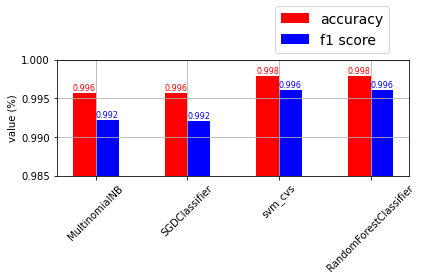

In [61]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
_width = 0.25
br1 = np.arange(len(classif)) 
#br2 = np.arange(len(classif)) #br1 + (_width/2) #[x + _width for x in br1]

a = ax.bar(br1,acc , color='r', label='accuracy', width = _width)
f = ax.bar(br1 + 0.25,f1 , color='b', label='f1 score', width = _width)

ax.bar_label(a, fmt='%.3f', padding=1, color='r', fontsize=8)
ax.bar_label(f, fmt='%.3f', padding=1, color='b', fontsize=8)

plt.xticks(br1 + (_width/2), classif)
plt.ylim([0.985,1.00])
plt.xticks(rotation = 45)
plt.ylabel('value (%)')
plt.grid()
plt.legend(fontsize=14, bbox_to_anchor=(0.6, 1))
plt.tight_layout()
plt.savefig('perf_comparison.png', facecolor='white',transparent=False)
plt.show()